In [1]:
%pip install -r requirements.txt

^C
Note: you may need to restart the kernel to use updated packages.


In [21]:
!mkdir extracted_images


A subdirectory or file extracted_images already exists.


In [1]:
import os
import nest_asyncio
from dotenv import load_dotenv
load_dotenv()


nest_asyncio.apply()

In [2]:
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.core import SimpleDirectoryReader
# Initialize an embedding model from Hugging Face using the "BAAI/bge-small-en" model.
embedding_model = AzureOpenAIEmbedding(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    model="text-embedding-3-large",
    deployment_name="text-embedding3",
    api_version="2024-02-01"
    
)
llm = AzureOpenAI(
    model="gpt-35-turbo-16k",
    deployment_name="GPT35-turboA",
    api_version="2024-02-01"
)

In [72]:
# source_docs=SimpleDirectoryReader('source_docs').load_data()

In [3]:
source_docs=SimpleDirectoryReader('test_data').load_data()

In [4]:
from llama_index.core import Settings
Settings.llm=llm
Settings.embed_model=embedding_model

## Preproceesing

In [11]:
from PIL import Image
import os
def verify_images(directory):
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        try:
            with Image.open(path) as img:
                print(f"{filename} is valid.")
        except IOError:
            print(f"Error opening {filename}; it may be corrupted or in an incorrect format.")

# Verify images before processing
verify_images('images')

figure-10-11.jpg is valid.
figure-13-12.jpg is valid.
figure-14-13.jpg is valid.
figure-14-14.jpg is valid.
figure-15-15.jpg is valid.
figure-15-16.jpg is valid.
figure-15-17.jpg is valid.
figure-15-18.jpg is valid.
figure-16-19.jpg is valid.
figure-16-20.jpg is valid.
figure-16-21.jpg is valid.
figure-16-22.jpg is valid.
figure-17-23.jpg is valid.
figure-18-24.jpg is valid.
figure-18-25.jpg is valid.
figure-18-26.jpg is valid.
figure-18-27.jpg is valid.
figure-18-28.jpg is valid.
figure-2-1.jpg is valid.
figure-2-2.jpg is valid.
figure-3-3.jpg is valid.
figure-3-4.jpg is valid.
figure-5-5.jpg is valid.
figure-6-6.jpg is valid.
figure-6-7.jpg is valid.
figure-7-8.jpg is valid.
figure-7-9.jpg is valid.
figure-8-10.jpg is valid.


In [10]:
import os

# Define the path to the poppler bin directory
poppler_path = r"C:\Users\ARUN\AppData\Local\poppler-24.02.0\Library\bin"

# Add the poppler path to the PATH environment variable
os.environ["PATH"] += os.pathsep + poppler_path

# Print the PATH environment variable to verify the addition
print(os.environ["PATH"])


D:\OtsukaInternship\Code\RAG\Test1\venv\Lib\site-packages\cv2\../../x64/vc14/bin;d:\OtsukaInternship\Code\RAG\Test1\venv\Scripts;D:\OtsukaInternship\Code\RAG\Test1\venv\Scripts;C:\WINDOWS\system32;C:\GnuWin32\bin;C:\Dev-Cpp\TDM-GCC-64\bin;C:\Program Files\nodejs;C:\Program Files\Git\cmd;C:\Program Files\PythonNew\Scripts;C:\Users\ARUN\AppData\Local\Programs\Python\Python311\Scripts;C:\Program Files\PythonNew;C:\Python310\Scripts\;C:\Python310\;C:\Program Files\PuTTY\;C:\Program Files\mongosh-1.6.1-win32-x64\bin;C:\Program Files\MongoDB\Server\6.0\bin;C:\Users\ARUN\AppData\Roaming\Python\Python312\Scripts;C:\Program Files\dotnet\;C:\MinGW\bin;D:\Files\VisualStudio\mainIde\VC\Tools\MSVC\14.39.33519\bin\Hostx64\x64;C:\Users\ARUN\miniconda3\Scripts\conda.exe;C:\Users\ARUN\miniconda3\Library\bin\conda.bat;C:\Users\ARUN\miniconda3\condabin\conda.bat;C:\Users\Arun\AppData\Roaming\npm\;C:\Program Files\Docker\Docker\resources\bin;C:\Program Files\Tesseract-OCR;C:\Users\ARUN\AppData\Local\pnpm;

In [9]:
from unstructured.partition.pdf import partition_pdf
from unstructured.staging.base import elements_to_json
import json 

raw_pdf_elements = partition_pdf(
    filename="test_data/GNN_DEEPRL.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir="images",
    extract_image_block_to_payload=False,
    strategy = "hi_res"
)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
from lens import Lens, LensProcessor
from PIL import Image
import torch
print(torch.cuda.is_available())

True


In [8]:
print(torch.cuda.is_available())

True


In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image
torch.set_default_device("cuda")

d:\OtsukaInternship\Code\RAG\Test1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:

torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(
    "MILVLG/imp-v1-3b",
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("MILVLG/imp-v1-3b", trust_remote_code=True)

Loading checkpoint shards: 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]
Some parameters are on the meta device device because they were offloaded to the cpu and disk.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
def process_and_caption_image(image_path, question):
    try:
        # Ensure image is loaded correctly
        image = Image.open(image_path).convert('RGB')
        text = (
            "A chat between a curious user and an artificial intelligence assistant. "
            "The assistant gives helpful, detailed, and polite answers to the user's questions. "
            "USER: <image>\nExtract all key features from the image you see. The image can contain a graph, "
            "chart or another data representation. The image can also contain other things. Use your judgement "
            "and describe the image in detail? ASSISTANT:"
        )
        input_ids = tokenizer(text, return_tensors='pt').input_ids
        image_tensor = model.image_preprocess(image)

        

        # Generate the answer
        with torch.no_grad():
            output_ids = model.generate(
                input_ids,
                max_new_tokens=100,
                images=image_tensor,
                use_cache=True
            )[0]
        
        return [tokenizer.decode(output_ids[input_ids.shape[1]:], skip_special_tokens=True).strip()]
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return []

In [16]:
# Directory and files setup
folder_path = 'images'
output_file = 'captions1_output.txt'
question = "Describe the image in detail and extract key features from it"

# Write captions to file and print
with open(output_file, 'w') as file:
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for filename in image_files:
        image_path = os.path.join(folder_path, filename)
        captions = process_and_caption_image(image_path, question)
        if captions:
            file.write(f"Captions for {filename}:\n")
            for i, caption in enumerate(captions):
                file.write(f"{i+1}. {caption}\n")
            file.write("\n")
        else:
            file.write(f"No captions generated for {filename}\n")

print(f"Captions have been saved to {output_file}")

Error processing image images\figure-10-11.jpg: Cannot copy out of meta tensor; no data!
Error processing image images\figure-13-12.jpg: Cannot copy out of meta tensor; no data!
Error processing image images\figure-14-13.jpg: Cannot copy out of meta tensor; no data!
Error processing image images\figure-14-14.jpg: Cannot copy out of meta tensor; no data!
Error processing image images\figure-15-15.jpg: Cannot copy out of meta tensor; no data!
Error processing image images\figure-15-16.jpg: Cannot copy out of meta tensor; no data!
Error processing image images\figure-15-17.jpg: Cannot copy out of meta tensor; no data!
Error processing image images\figure-15-18.jpg: Cannot copy out of meta tensor; no data!
Error processing image images\figure-16-19.jpg: Cannot copy out of meta tensor; no data!
Error processing image images\figure-16-20.jpg: Cannot copy out of meta tensor; no data!
Error processing image images\figure-16-21.jpg: Cannot copy out of meta tensor; no data!
Error processing imag

In [59]:
FinalText=main_processing_pipeline()

In [60]:
FinalText

'Attention Is All You Need\nAshishVaswani∗ NoamShazeer∗ NikiParmar∗ JakobUszkoreit∗\nGoogleBrain GoogleBrain GoogleResearch GoogleResearch\navaswani@google.com noam@google.com nikip@google.com usz@google.com\nLlionJones∗ AidanN.Gomez∗ † ŁukaszKaiser∗\nGoogleResearch UniversityofToronto GoogleBrain\nllion@google.com aidan@cs.toronto.edu lukaszkaiser@google.com\nIlliaPolosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThedominantsequencetransductionmodelsarebasedoncomplexrecurrentor\nconvolutionalneuralnetworksthatincludeanencoderandadecoder. Thebest\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer,\nbasedsolelyonattentionmechanisms,dispensingwithrecurrenceandconvolutions\nentirely. Experiments on two machine translation tasks show these models to\nbesuperiorinqualitywhilebeingmoreparallelizableandrequiringsignificantly\nless time to train. Our model achieves 28.4 BLEU on the WMT 2014 E

In [47]:
source_docs

[Document(id_='f2becc38-15c9-4cbc-89a7-8293fe695679', embedding=None, metadata={'page_label': '1', 'file_name': 'attention_is_all_you_need.pdf', 'file_path': 'd:\\OtsukaInternship\\Code\\RAG\\Test1\\test_data\\attention_is_all_you_need.pdf', 'file_type': 'application/pdf', 'file_size': 569417, 'creation_date': '2024-07-03', 'last_modified_date': '2024-07-02'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='Attention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.comNoam Shazeer∗\nGoogle Brain\nnoam@google.comNiki Parmar∗\nGoogle Research\nnikip@google.comJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.comAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser∗\nGoogle Bra

# Advanced RAG Techniques

## Chunking with Overlap (Baseline)

Parse source_docs into nodes

In [ ]:
from llama_index.core.node_parser import SimpleNodeParser


baseline_parser = SimpleNodeParser.from_defaults(
    chunk_overlap=200,  # Overlap of 200 characters between chunks
    chunk_size=1024     # Each chunk consists of 1024 characters
)

# Use the created parser instance to extract nodes from the documents.
# The 'get_nodes_from_documents' method processes the documents in 'source_docs'
# and extracts structured nodes based on the parser's configuration.
baseline_nodes = baseline_parser.get_nodes_from_documents(source_docs)
Settings.node_parser=baseline_parser


: 

In [ ]:
from llama_index.core import VectorStoreIndex


baseline_index = VectorStoreIndex(
    baseline_nodes,              # Nodes to be indexed # Service context providing necessary components
)

baseline_index.storage_context.persist(
    persist_dir="baseline_index"  # Directory name for storing the index
)

: 

In [ ]:
# Convert the baseline index into a query engine capable of finding the top 3 most similar entries.
baseline_query_engine = baseline_index.as_query_engine(similarity_top_k=3)

baseline_response = baseline_query_engine.query('What is the main advantage of using the Transformer model over traditional RNN-based models?')

# Retrieve the response from the query.
baseline_response.response

: 

## Sentence Window Parser

In [ ]:
from llama_index.core.node_parser import SentenceWindowNodeParser
from llama_index.core import Settings



#   original_text_metadata_key: The key for storing the original text data in the metadata.
sentence_parser = SentenceWindowNodeParser.from_defaults(
    window_size=6,  # Number of sentences in each window
    window_metadata_key="window",  # Metadata key for window information
    original_text_metadata_key="original_text"  # Metadata key for original text
)

# Use the sentence parser to parse nodes from documents.
# This method processes the documents in 'source_docs' and extracts structured nodes,
# with each node representing a window of sentences.
sentence_nodes = sentence_parser.get_nodes_from_documents(source_docs)
Settings.node_parser=sentence_parser

: 

In [ ]:
from llama_index.core import VectorStoreIndex


sentence_index = VectorStoreIndex(
    sentence_nodes,         # Nodes obtained from sentence-level parsing
)

#   persist_dir: The name of the directory where the index will be stored.
sentence_index.storage_context.persist(
    persist_dir="sentence_index"  # Directory name for storing the index
)

: 

In [ ]:
from llama_index.core.postprocessor import MetadataReplacementPostProcessor


sentence_query_engine = sentence_index.as_query_engine(
    similarity_top_k=3,  # Find the top 3 most similar entries
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window")
    ]
)

sentence_response = sentence_query_engine.query('What is the Scaled Dot-Product Attention algorithm, Give tis formula')


response = sentence_response.response
response

: 

## Automerging Retrival (Using Hierarchical Nodes)

In [ ]:
from llama_index.core.node_parser import HierarchicalNodeParser
from llama_index.core import Settings


hierarchical_parser = HierarchicalNodeParser.from_defaults()


hierarchical_nodes = hierarchical_parser.get_nodes_from_documents(source_docs)
Settings.node_parser=hierarchical_parser

: 

In [ ]:
from llama_index.core import VectorStoreIndex


hierarchical_index = VectorStoreIndex(
    hierarchical_nodes,           # Nodes structured hierarchically  # Service context with essential components
)

# Persist the hierarchical index to a directory. This action saves the current state of the index on disk,
# enabling the index to be reloaded and reused in the future. It ensures the persistence and availability
# of the indexed data for later use.
# Parameters:
#   persist_dir: The name of the directory where the index will be stored.
hierarchical_index.storage_context.persist(
    persist_dir="hierarchical_index"  # Directory name for storing the index
)

: 

In [ ]:
from llama_index.core.retrievers import AutoMergingRetriever
from llama_index.core.query_engine import RetrieverQueryEngine

# Initialize an AutoMergingRetriever with the hierarchical index.
# AutoMergingRetriever is used for retrieving data from an index by automatically merging results
# from multiple queries or sources. It's particularly useful for complex data structures like a hierarchical index.
# Parameters:
#   hierarchical_index.as_retriever(similarity_top_k=3): Converts the hierarchical index into a retriever
#                                                        configured to find the top 3 most similar entries.
#   storage_context: Specifies the storage context from the hierarchical index for data management.
#   verbose: Enables verbose output, providing more detailed information during retrieval operations.
retriever = AutoMergingRetriever(
    hierarchical_index.as_retriever(similarity_top_k=3),
    storage_context=hierarchical_index.storage_context,
    verbose=True
)

# Create a RetrieverQueryEngine using the AutoMergingRetriever.
# RetrieverQueryEngine is a query engine that uses a specified retriever for querying the indexed data.
# It allows for complex query operations, especially in conjunction with retrievers like AutoMergingRetriever.
amretriever_query_engine = RetrieverQueryEngine.from_args(retriever)

# Perform a query using the AMRetriever query engine.
amretriever_response = amretriever_query_engine.query('What do you observer when youn look at Figure 1?')

response = amretriever_response.response

: 

In [ ]:
response

: 

# Evaluating RAG Performance

## Manual

In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from rouge import Rouge
from bert_score import score

def calculate_metrics(predictions, references):
    vectorizer = CountVectorizer()
    pred_vec = vectorizer.fit_transform(predictions)
    ref_vec = vectorizer.transform(references)

    # Cosine Similarity for relevancy
    cos_sim = cosine_similarity(pred_vec, ref_vec).diagonal()

    # Initialize ROUGE for precision and recall
    rouge = Rouge()
    rouge_scores = rouge.get_scores(predictions, references, avg=True)

    # BERTScore for answer similarity
    P, R, F1 = score(predictions, references, lang="en", rescale_with_baseline=True)

    metrics = {
        'cosine_similarity': cos_sim.mean(),
        'ROUGE-1': rouge_scores['rouge-1']['f'],
        'ROUGE-2': rouge_scores['rouge-2']['f'],
        'ROUGE-L': rouge_scores['rouge-l']['f'],
        'BERTScore F1': F1.mean().item()  # Average F1 score
    }
    return metrics

d:\OtsukaInternship\Code\RAG\Test1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:


def ask_questions(csv_file_path):
    # Load the questions and expected answers
    qa_data = pd.read_csv(csv_file_path)

    # Prepare a list for collecting results
    results_data = []
    baseline_preds, sentence_preds, hierarchical_preds = [], [], []

    # Loop over each row in the DataFrame
    for index, row in qa_data.iterrows():
        question = row['Question']
        expected_answer = row['Answer']
        
        # Query each engine
        baseline_response = baseline_query_engine.query(question).response
        sentence_response = sentence_query_engine.query(question).response
        amretriever_response = amretriever_query_engine.query(question).response
        
        # Collect predictions for metrics
        baseline_preds.append(baseline_response)
        sentence_preds.append(sentence_response)
        hierarchical_preds.append(amretriever_response)
        


        # Append the results
        results_data.append({
            'Question': question,
            'ExpectedAnswer': expected_answer,
            'BaselineAnswer': baseline_response,
            'SentenceAnswer': sentence_response,
            'HierarchicalAnswer': amretriever_response
        })
            # Calculate metrics for each response type

    # Create a DataFrame from collected data
    results = pd.DataFrame(results_data)
    return results,baseline_preds, sentence_preds, hierarchical_preds,qa_data


In [23]:
results,baseline_preds, sentence_preds, hierarchical_preds,qa_data = ask_questions('questions.csv')

Retrying llama_index.llms.openai.base.OpenAI._chat in 0.07390618893315459 seconds as it raised RateLimitError: Error code: 429 - {'error': {'code': '429', 'message': 'Requests to the ChatCompletions_Create Operation under Azure OpenAI API version 2024-02-01 have exceeded token rate limit of your current OpenAI S0 pricing tier. Please retry after 1 second. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit.'}}.


> Merging 2 nodes into parent node.
> Parent node id: cf18c95a-0369-4c3e-a1be-52d368e2d7ef.
> Parent node text: Table 2: The Transformer achieves better BLEU scores than previous state-of-the-art models on the...



In [24]:
baseline_metrics = calculate_metrics(baseline_preds, qa_data['Answer'].tolist())
sentence_metrics = calculate_metrics(sentence_preds, qa_data['Answer'].tolist())
hierarchical_metrics = calculate_metrics(hierarchical_preds, qa_data['Answer'].tolist())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_metrics(baseline_metrics, sentence_metrics, hierarchical_metrics):
    # Create a DataFrame from the metrics
    metrics_data = {
        "Engine": ["Baseline", "Sentence Window", "Hierarchical"] * len(baseline_metrics),
        "Metric Value": list(baseline_metrics.values()) + list(sentence_metrics.values()) + list(hierarchical_metrics.values()),
        "Metric": ["Cosine Similarity", "ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore F1"] * 3
    }
    
    df_metrics = pd.DataFrame(metrics_data)

    # Initialize the matplotlib figure
    plt.figure(figsize=(10, 6))

    # Plotting
    sns.barplot(x="Metric", y="Metric Value", hue="Engine", data=df_metrics)
    plt.title('Comparison of Query Engines across Various Metrics')
    plt.ylabel('Metric Value')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.legend(title='Engine')
    
    # Show plot
    plt.tight_layout()
    plt.show()

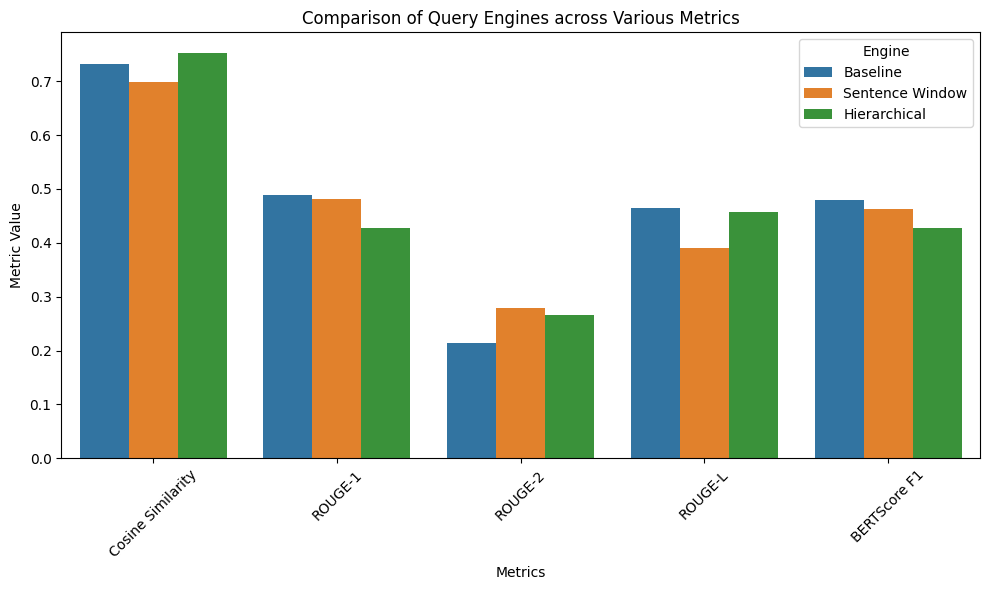

In [26]:
plot_metrics(baseline_metrics, sentence_metrics, hierarchical_metrics)

In [35]:
print("Results:")
print(results.to_string(index=False))

# Save results to CSV
results.to_csv('query_results.csv', index=False)
print("Results saved to 'query_results.csv'.")

Results:
                                                                                                                                                                             Question                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              ExpectedAnswer                                                                                                                                                              

## RAGAS

### Creating Test DATA

In [83]:
from ragas.testset.generator import TestsetGenerator
import random

# Initialize a TestsetGenerator using its default settings.
# TestsetGenerator is used for generating test datasets, typically for model evaluation or testing.
# The 'from_default' method sets up the generator with default configurations.
testsetgenerator = TestsetGenerator.from_llama_index(
    generator_llm=llm,
    critic_llm=llm,
    embeddings=embedding_model,
)

# Specify the sample size for the source documents.
# This determines how many documents will be randomly selected from the source documents.
sample_size = 10

# Define the number of questions to be included in the test set.
# This will set how many test cases or questions the test set will contain.
num_questions = 10

# Generate a test dataset from a random sample of source documents.
# 'random.sample' is used to randomly select a subset of documents from the source.
# The test set is then generated based on these documents.
# Parameters:
#   random.sample(source_docs, sample_size): A randomly selected subset of source documents.
#   test_size: The number of questions or test cases to generate in the test set.
testset = testsetgenerator.generate_with_llamaindex_docs(
    random.sample(source_docs, sample_size),  # Randomly selected documents
    test_size=num_questions                    # Number of questions in the test set
)

Filename and doc_id are the same for all nodes.                 
Generating: 100%|██████████| 10/10 [02:25<00:00, 14.53s/it]


### Minor cleanup and reformatting

In [84]:
import re

test_df = testset.to_pandas()
# Define the regex pattern to match any character that is NOT a letter, a number, '.', ',', or '?'
pattern = r"[^a-zA-Z0-9.,? ]"

# Define a function to replace special characters in a string
def remove_special_chars(s):
    return re.sub(pattern, '', str(s))

# Apply the function to each cell in the DataFrame
test_df = test_df.applymap(remove_special_chars)


test_questions = test_df['question'].values.tolist()
test_answers = [[item] for item in test_df['ground_truth'].values.tolist()]

test_df

C:\Users\ARUN\AppData\Local\Temp\ipykernel_4548\2846673957.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_df = test_df.applymap(remove_special_chars)


,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What haematological parameters were measured i...,Bonacic and Macdonald n n n n390 Animal Welfa...,The haematological parameters measured in the ...,simple,"pagelabel 5, filename The physiological impact...",True
1,What are the characteristics of the degenerate...,astructural image of the distal phrenic nerve ...,The characteristics of the degenerate axons in...,simple,"pagelabel 383, filename Neurological Causes of...",True
2,What are some studies that have evaluated the ...,"482.n9. Mundie TG, Dodd KT, Lagutchik M. Relat...",Relationship of functional residual capacity t...,simple,"pagelabel 151, filename Respiratory mechanics ...",True
3,How do guanacos and other SACs lose heat from ...,absorption of water by the bre and thus its po...,Guanacos and other SACs lose heat from their b...,simple,"pagelabel 1454, filename Relationships between...",True
4,How do llamas and alpacas use their thermal wi...,have temperatures of only 41.1 8Ct on42.28C. ...,Llamas and alpacas use their thermal windows f...,simple,"pagelabel 1454, filename Relationships between...",True
5,How does infrared thermography assist in ident...,"net al ., 1997, which may play a rolenin tissu...",Infrared thermography assists in identifying h...,reasoning,"pagelabel 1455, filename Relationships between...",True
6,What were the physiological and physical chang...,Impact of wool harvesting in vicunas n n n nAn...,Capture and transport caused changes in blood ...,reasoning,"pagelabel 10, filename The physiological impac...",True
7,How does protein denaturation at high temperat...,have temperatures of only 41.1 8Ct on42.28C. ...,The answer to given question is not present in...,multicontext,"pagelabel 1454, filename Relationships between...",True
8,What contributes to capture myopathy in whitet...,Impact of wool harvesting in vicunas n n n nAn...,Factors affecting capture myopathy in whitetai...,multicontext,"pagelabel 14, filename The physiological impac...",True
9,What is the effect of the postcapture manageme...,Nativa nChilena Logros y perspectivas pp 716....,The effect of postcapture management strategy ...,reasoning,"pagelabel 14, filename The physiological impac...",True


In [85]:
import asyncio
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
    answer_similarity,
    answer_correctness
)
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from ragas.integrations.llama_index import evaluate
import pandas as pd
import time
import httpx 

# List of evaluation metrics functions to be used.
metrics = [
    faithfulness,           # Evaluates faithfulness of the response to the source material.
    answer_relevancy,       # Assesses relevance of the response to the query.
    context_precision,      # Measures precision of the context in the response.
    context_recall,         # Measures recall of the context in the response.
    answer_correctness,     # Checks correctness of the answer.
    answer_similarity,      # Evaluates similarity of the answer to a reference answer.
]

# A list to collect individual result DataFrames.
results_list = []

In [91]:
@retry(stop=stop_after_attempt(5), wait=wait_exponential(min=1, max=60), retry=retry_if_exception_type(httpx.HTTPStatusError))
def safe_evaluate(query_engine, metrics, dataset, llm, embeddings):
    return evaluate(query_engine=query_engine, metrics=metrics, dataset=dataset, llm=llm, embeddings=embeddings,raise_exceptions=False)

In [92]:
def evaluate_and_append(query_engine, technique):
    # Evaluate the query engine.
    result = safe_evaluate(query_engine=query_engine, metrics=metrics, dataset=test_df, llm=llm, embeddings=embedding_model)
    # Add a 'technique' column to the result DataFrame.
    result['technique'] = technique

    # Add the result DataFrame to the results list.
    results_list.append(result)

    # Sleep to handle rate limits.
    # time.sleep(60)

In [93]:
evaluate_and_append(baseline_query_engine, 'chunks_with_overlap')

Evaluating:   2%|▏         | 1/60 [00:01<01:26,  1.47s/it]n values greater than 1 not support for LlamaIndex LLMs
n values greater than 1 not support for LlamaIndex LLMs
Evaluating:  55%|█████▌    | 33/60 [01:12<00:37,  1.39s/it]Runner in Executor raised an exception
Traceback (most recent call last):
  File "d:\OtsukaInternship\Code\RAG\Test1\venv\Lib\site-packages\openai\_base_client.py", line 1589, in _request
    response.raise_for_status()
  File "d:\OtsukaInternship\Code\RAG\Test1\venv\Lib\site-packages\httpx\_models.py", line 761, in raise_for_status
    raise HTTPStatusError(message, request=request, response=self)
httpx.HTTPStatusError: Client error '429 Too Many Requests' for url 'https://openai-for-internship-southindia.openai.azure.com//openai/deployments/GPT35-turboA/chat/completions?api-version=2024-02-01'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/429

During handling of the above exception, another exception occurred:

Traceback

In [94]:
evaluate_and_append(sentence_query_engine, 'sentence_window')

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]n values greater than 1 not support for LlamaIndex LLMs
n values greater than 1 not support for LlamaIndex LLMs
n values greater than 1 not support for LlamaIndex LLMs
n values greater than 1 not support for LlamaIndex LLMs
n values greater than 1 not support for LlamaIndex LLMs
Evaluating:  50%|█████     | 30/60 [01:06<00:20,  1.49it/s]Runner in Executor raised an exception
Traceback (most recent call last):
  File "d:\OtsukaInternship\Code\RAG\Test1\venv\Lib\site-packages\openai\_base_client.py", line 1589, in _request
    response.raise_for_status()
  File "d:\OtsukaInternship\Code\RAG\Test1\venv\Lib\site-packages\httpx\_models.py", line 761, in raise_for_status
    raise HTTPStatusError(message, request=request, response=self)
httpx.HTTPStatusError: Client error '429 Too Many Requests' for url 'https://openai-for-internship-southindia.openai.azure.com//openai/deployments/GPT35-turboA/chat/completions?api-version=2024-02-01'
For more

In [95]:
evaluate_and_append(amretriever_query_engine, 'Automerging_Retrival')


Running Query Engine:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]n values greater than 1 not support for LlamaIndex LLMs
n values greater than 1 not support for LlamaIndex LLMs
Evaluating:  28%|██▊       | 17/60 [00:20<00:34,  1.26it/s]Retrying llama_index.llms.openai.base.OpenAI._achat in 0.35469620224909815 seconds as it raised RateLimitError: Error code: 429 - {'error': {'code': '429', 'message': 'Requests to the ChatCompletions_Create Operation under Azure OpenAI API version 2024-02-01 have exceeded token rate limit of your current OpenAI S0 pricing tier. Please retry after 15 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit.'}}.
Retrying llama_index.llms.openai.base.OpenAI._achat in 0.6749207257867742 seconds as it raised RateLimitError: Error code: 429 - {'error': {'code': '429', 'message': 'Requests to the ChatCompletions_Create Operation under Azure OpenAI API version 2024-02-01 have exceeded token rate limit of your curren

In [96]:
# Convert each Result object's items to a dictionary and collect them in a list
dict_list = [dict(result.items()) for result in results_list]

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(dict_list)

results_df

,faithfulness,answer_relevancy,context_precision,context_recall,answer_correctness,answer_similarity,technique
0,0.881834,0.819965,0.857143,0.900000,0.697965,0.799097,chunks_with_overlap
1,0.830051,0.856361,1.000000,0.708889,0.592229,0.801524,sentence_window
2,0.834921,0.851566,0.875000,0.983333,0.629101,0.801119,Automerging_Retrival


In [ ]:
%pip install mlflow azureml-mlflow -U -q